In [53]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys
import string
import pickle

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [16]:
def fetch_data_train(path='DATA'):
    data = pd.read_csv(os.path.join(path, 'train.csv'))
    data_positive = data.loc[data['target'] == 1][:80000]
    data_negative = data.loc[data['target'] == 0][:80000]
    
    data = data_positive.append(data_negative, ignore_index=True, sort=False)
    data = data.sample(frac=1).reset_index(drop=True)
    
    X = data.drop(['qid', 'target'], axis=1)
    y = data['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return X_train, X_test, y_train, y_test

def fetch_data_test(path='DATA'):
    train = pd.read_csv(os.path.join(path, 'train.csv'))
    test = pd.read_csv(os.path.join(path, 'test.csv'))
    
    X_train = train.drop(['qid', 'target'], axis=1)
    y_train = train['target']
    X_test = train.drop(['qid'], axis=1)
    
    return X_train, X_test, y_train

In [17]:
X_train, X_test, y_train, y_test = fetch_data_train()

In [19]:
X_train.head()

,question_text
124518,Does anybody still believe in the theory of ev...
26033,I've matched with about 60 women on Tinder and...
3364,How can I buy a bomb which is capable of killi...
27636,Would you take your dog to an at-home dog cast...
127008,Can people with ASD think of people beyond the...


In [28]:
with open(os.path.join('pickles', 'stopwords.pickle'), 'rb') as handle:
    STOPWORDS = pickle.load(handle)

In [36]:
class NumWordsTransform(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        X['num_words'] = X['question_text'].apply(lambda x: len(str(x).split()))
        return X
    
class NumUniqueWordsTransform(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        X['num_unique_words'] = X['question_text'].apply(lambda x: len(set(str(x).split())))
        return X
    
class NumCharsTransform(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        X['num_chars'] = X['question_text'].apply(lambda x: len(str(x)))
        return X

class NumStopWordsTransform(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords):
        self.STOPWORDS = stopwords
    
    def transform(self, X, y=None):
        X['num_stopwords'] = X['question_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in self.STOPWORDS]))
        return X
    
class NumPunctuationTransform(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        X['num_punctuations'] = X['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
        return X
    
class NumWordsUpperTransform(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        X['num_words_upper'] = X['question_text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
        return X

class NumTitleTransform(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        X['num_words_title'] = X['question_text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
        return X
    
class MeanWordLengthTransform(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['mean_word_len'] = X['question_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
        return X

In [37]:
pipeline = Pipeline([
    ('num_words', NumWordsTransform()),
    ('num_unique_words', NumUniqueWordsTransform()),
    ('num_chars', NumCharsTransform()),
    ('num_stopwords', NumStopWordsTransform(stopwords=STOPWORDS)),
    ('num_punctuations', NumPunctuationTransform()),
    ('num_words_upper', NumWordsUpperTransform()),
    ('num_words_title', NumTitleTransform()),
    ('mean_word_len', MeanWordLengthTransform())
])

In [42]:
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

In [43]:
X_train.head()

,question_text,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
124518,Does anybody still believe in the theory of ev...,16,16,98,7,1,0,1,5.187500
26033,I've matched with about 60 women on Tinder and...,32,31,176,17,7,1,3,4.531250
3364,How can I buy a bomb which is capable of killi...,14,14,66,7,1,1,2,3.785714
27636,Would you take your dog to an at-home dog cast...,16,15,83,9,2,0,1,4.250000
127008,Can people with ASD think of people beyond the...,11,10,67,4,1,1,1,5.181818


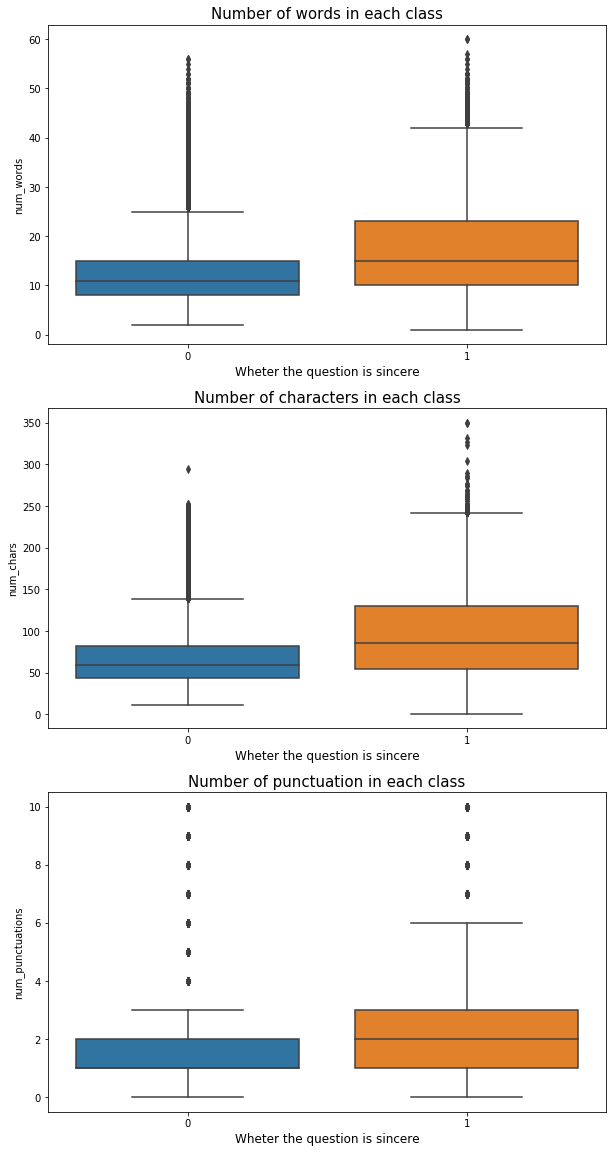

In [60]:
X = X_train
X['target'] = y_train

X['num_words'].loc[X['num_words'] > 60] = 60
X['num_punctuations'].loc[X['num_punctuations'] > 10] = 10
X['num_chars'].loc[X['num_chars'] > 350] = 350

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=X, ax=axes[0])
axes[0].set_xlabel('Wheter the question is sincere', fontsize=12)
axes[0].set_title('Number of words in each class', fontsize=15)

sns.boxplot(x='target', y='num_chars', data=X, ax=axes[1])
axes[1].set_xlabel('Wheter the question is sincere', fontsize=12)
axes[1].set_title('Number of characters in each class', fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=X, ax=axes[2])
axes[2].set_xlabel('Wheter the question is sincere', fontsize=12)
axes[2].set_title('Number of punctuation in each class', fontsize=15)

plt.show()